In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import csv
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from models import sequence_models

In [2]:
dataset = pd.read_csv('./trainingandtestdata/training.1600000.processed.noemoticon.csv',delimiter=',',encoding='latin-1',names=['sentiment','id','time','query','tweeter','sentences'])
dataset = dataset.sample(frac=1)

In [3]:
def data_cleaning(sentence):
    #removing @ user
    clean_sentence = re.sub(r'@[A-Za-z0-9]+','',sentence)
    #removing http links
    clean_sentence = re.sub('https?://[A-Za-z0-9./]+','',clean_sentence)
    #removing # tag and numbers
    clean_sentence = re.sub("[^a-zA-Z]", " ", clean_sentence)
    return clean_sentence

In [4]:
dataset['clean_sentence'] = [data_cleaning(i) for i in dataset.sentences]

In [5]:
dataset.head()

,sentiment,id,time,query,tweeter,sentences,clean_sentence
1153354,4,1978814481,Sun May 31 00:33:42 PDT 2009,NO_QUERY,sintaks,"@Justineedge No complaints. Still, need to get...",No complaints Still need to get out more
1300577,4,2006667070,Tue Jun 02 11:30:20 PDT 2009,NO_QUERY,lelandstrott,maybe getting tickets to see the killers in au...,maybe getting tickets to see the killers in au...
1295129,4,2003642178,Tue Jun 02 06:54:00 PDT 2009,NO_QUERY,SlimPerfect,@quelleheure4 Thank you so much for the kind p...,Thank you so much for the kind post Truly a...
274174,0,1990552235,Mon Jun 01 05:10:03 PDT 2009,NO_QUERY,princessimmie,i feel like watching the o.c. im sick of my ow...,i feel like watching the o c im sick of my ow...
1037176,4,1956480740,Thu May 28 21:58:26 PDT 2009,NO_QUERY,Littleraven89,2 new bosses down in Ulduar tonight sweet,new bosses down in Ulduar tonight sweet


In [6]:
print("Number of unique sentiments: ",len(dataset['sentiment'].unique()))
print("Total number of sentences: ",dataset.shape[0])
print('Maximum len of sentence in data is {}'.format(np.max([len(x) for x in dataset.clean_sentence])))

Number of unique sentiments:  2
Total number of sentences:  1600000
Maximum len of sentence in data is 366


In [7]:
train_data = dataset.clean_sentence[:int(0.8*dataset.shape[0])]
train_label = dataset.sentiment[:int(0.8*dataset.shape[0])]
train_label = train_label.replace(4,1)

val_data = dataset.clean_sentence[int(0.8*dataset.shape[0]):]
val_label = dataset.sentiment[int(0.8*dataset.shape[0]):]
val_label = val_label.replace(4,1)

In [8]:
tokenizer = Tokenizer(oov_token="<oov_token>")
tokenizer.fit_on_texts(train_data)

sequence = tokenizer.texts_to_sequences(train_data)
train_padded_sequence = pad_sequences(sequence,truncating='post',maxlen=334)

sequence = tokenizer.texts_to_sequences(val_data)
val_padded_sequence = pad_sequences(sequence,truncating='post',maxlen=334)

In [10]:
glove_file = './glove.twitter.27B/glove.twitter.27B.100d.txt'

glove_embeddings = {}

with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs


In [11]:
word_index = tokenizer.word_index
vocab_size = len(word_index)
embedding_dims = 100

EMBEDDINGS_MATRIX = np.zeros((len(tokenizer.word_index)+1, embedding_dims))

for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [12]:
def plot_graph(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [13]:
model = sequence_models()

In [14]:
nn_model = model.nn_model(vocab_size, embedding_dims=embedding_dims,max_len=334,embedding_matrix= EMBEDDINGS_MATRIX)
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
nn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 334, 100)          23942900  
                                                                 
 flatten (Flatten)           (None, 33400)             0         
                                                                 
 dense (Dense)               (None, 64)                2137664   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

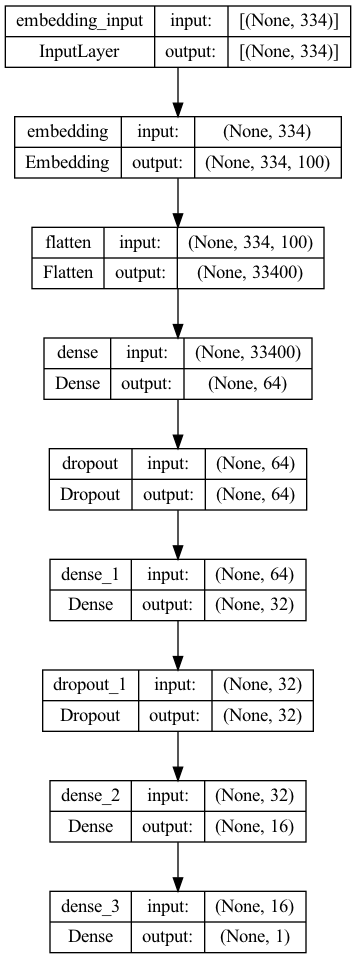

In [15]:
plot_model(nn_model,to_file="nn_model.png", show_shapes=True,show_layer_names=True)

In [16]:
nn_history = nn_model.fit(train_padded_sequence,train_label, epochs=5,validation_data=(val_padded_sequence,val_label))

Epoch 1/5


2022-10-06 17:14:03.833718: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


40000/40000 [==============================] - 134s 3ms/step - loss: 0.5054 - accuracy: 0.7495 - val_loss: 0.4897 - val_accuracy: 0.7685
Epoch 2/5
40000/40000 [==============================] - 134s 3ms/step - loss: 0.4786 - accuracy: 0.7684 - val_loss: 0.4697 - val_accuracy: 0.7751
Epoch 3/5
40000/40000 [==============================] - 133s 3ms/step - loss: 0.4659 - accuracy: 0.7766 - val_loss: 0.4703 - val_accuracy: 0.7772
Epoch 4/5
40000/40000 [==============================] - 134s 3ms/step - loss: 0.4574 - accuracy: 0.7822 - val_loss: 0.4627 - val_accuracy: 0.7780
Epoch 5/5
40000/40000 [==============================] - 135s 3ms/step - loss: 0.4508 - accuracy: 0.7862 - val_loss: 0.4682 - val_accuracy: 0.7790


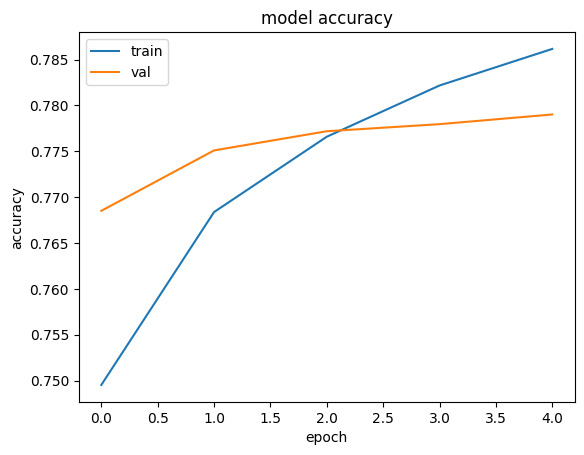

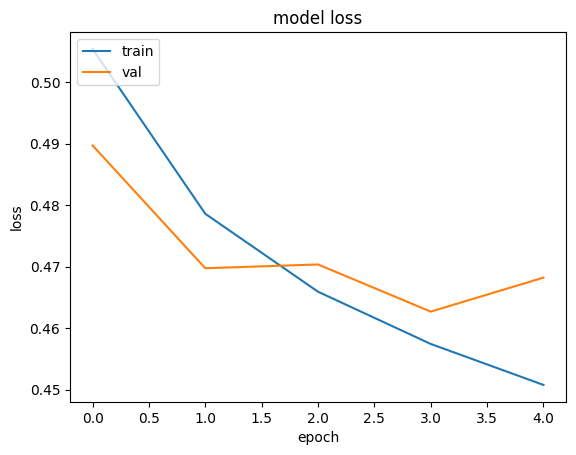

In [17]:
plot_graph(nn_history)

In [18]:
rnn_model = model.rnn_model(vocab_size, embedding_dims=embedding_dims,max_len=334,embedding_matrix= EMBEDDINGS_MATRIX)
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
rnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 334, 100)          23942900  
                                                                 
 simple_rnn (SimpleRNN)      (None, 334, 32)           4256      
                                                                 
 dropout_2 (Dropout)         (None, 334, 32)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                

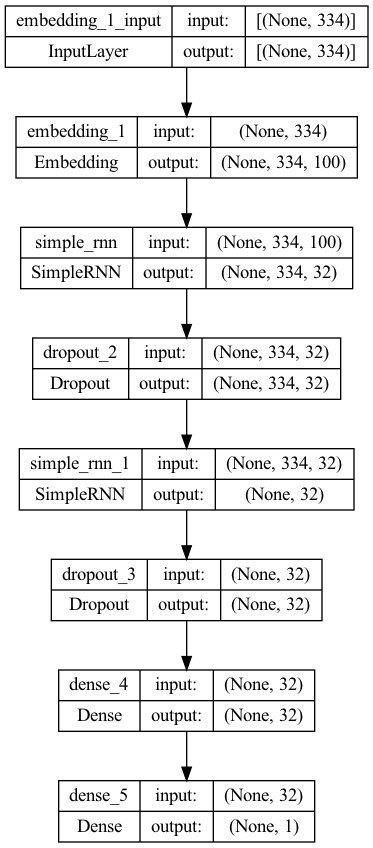

In [19]:
plot_model(rnn_model,to_file="rnn_model.png", show_shapes=True,show_layer_names=True)

In [20]:
rnn_history = rnn_model.fit(train_padded_sequence,train_label, epochs=5,validation_data=(val_padded_sequence,val_label))

Epoch 1/5
40000/40000 [==============================] - 1722s 43ms/step - loss: 0.4581 - accuracy: 0.7842 - val_loss: 0.4249 - val_accuracy: 0.8059
Epoch 2/5
40000/40000 [==============================] - 1661s 42ms/step - loss: 0.4313 - accuracy: 0.8010 - val_loss: 0.4278 - val_accuracy: 0.8096
Epoch 3/5
40000/40000 [==============================] - 1649s 41ms/step - loss: 0.4255 - accuracy: 0.8042 - val_loss: 0.4176 - val_accuracy: 0.8113
Epoch 4/5
40000/40000 [==============================] - 1624s 41ms/step - loss: 0.4227 - accuracy: 0.8059 - val_loss: 0.4218 - val_accuracy: 0.8105
Epoch 5/5
40000/40000 [==============================] - 2287s 57ms/step - loss: 0.4214 - accuracy: 0.8066 - val_loss: 0.4286 - val_accuracy: 0.8077


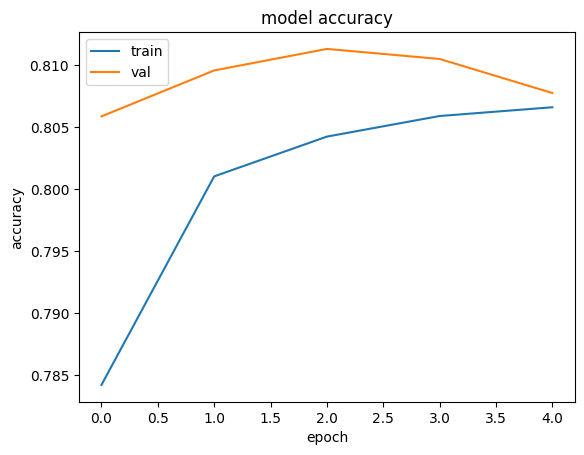

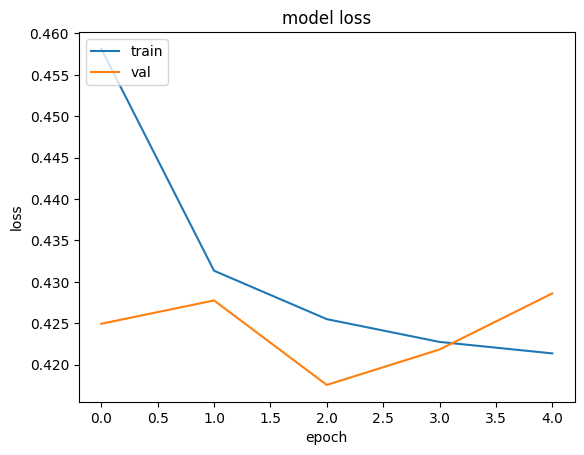

In [21]:
plot_graph(rnn_history)

In [22]:
gru_model = model.gru_model(vocab_size, embedding_dims=embedding_dims,max_len=334,embedding_matrix= EMBEDDINGS_MATRIX)
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 334, 100)          23942900  
                                                                 
 gru (GRU)                   (None, 334, 32)           12864     
                                                                 
 dropout_4 (Dropout)         (None, 334, 32)           0         
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                

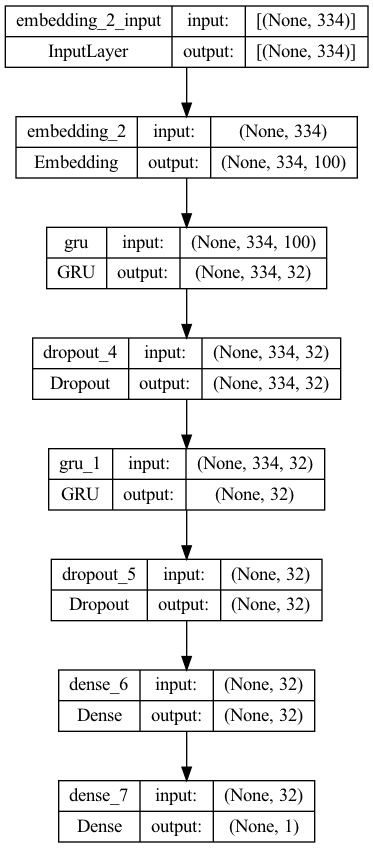

In [23]:
plot_model(gru_model,to_file="gru_model.png", show_shapes=True,show_layer_names=True)

In [24]:
gru_history = gru_model.fit(train_padded_sequence,train_label, epochs=5,validation_data=(val_padded_sequence,val_label))

Epoch 1/5
40000/40000 [==============================] - 3129s 78ms/step - loss: 0.4281 - accuracy: 0.8016 - val_loss: 0.4037 - val_accuracy: 0.8173
Epoch 2/5
40000/40000 [==============================] - 3169s 79ms/step - loss: 0.4053 - accuracy: 0.8149 - val_loss: 0.3977 - val_accuracy: 0.8210
Epoch 3/5
40000/40000 [==============================] - 3165s 79ms/step - loss: 0.3996 - accuracy: 0.8184 - val_loss: 0.3982 - val_accuracy: 0.8215
Epoch 4/5
40000/40000 [==============================] - 3155s 79ms/step - loss: 0.3965 - accuracy: 0.8199 - val_loss: 0.3974 - val_accuracy: 0.8233
Epoch 5/5
40000/40000 [==============================] - 36788s 920ms/step - loss: 0.3940 - accuracy: 0.8213 - val_loss: 0.3951 - val_accuracy: 0.8236


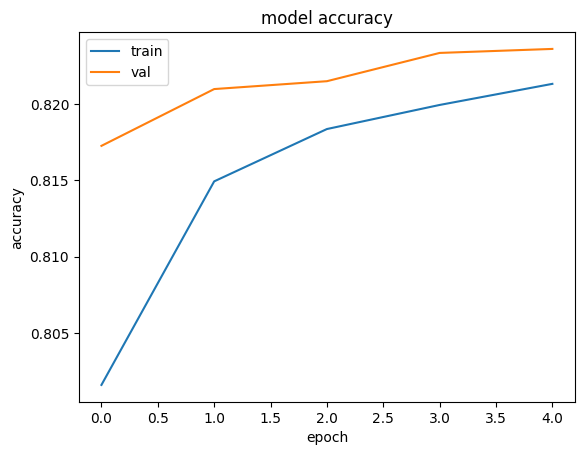

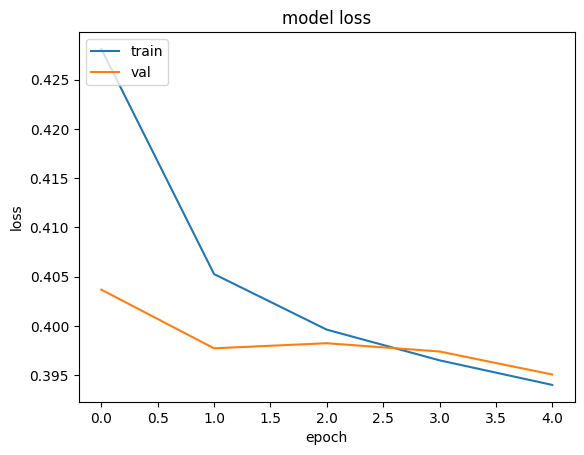

In [25]:
plot_graph(gru_history)

In [26]:
lstm_model = model.lstm_model(vocab_size, embedding_dims=embedding_dims,max_len=334,embedding_matrix= EMBEDDINGS_MATRIX)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 334, 100)          23942900  
                                                                 
 lstm (LSTM)                 (None, 334, 32)           17024     
                                                                 
 dropout_6 (Dropout)         (None, 334, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                

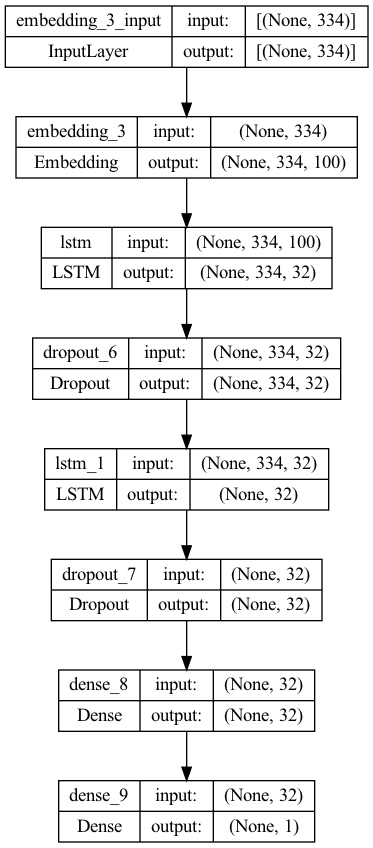

In [27]:
plot_model(lstm_model,to_file="lstm_model.png", show_shapes=True,show_layer_names=True)

In [28]:
lstm_history = lstm_model.fit(train_padded_sequence,train_label, epochs=5,validation_data=(val_padded_sequence,val_label))

Epoch 1/5
40000/40000 [==============================] - 4656s 116ms/step - loss: 0.4282 - accuracy: 0.8018 - val_loss: 0.4018 - val_accuracy: 0.8179
Epoch 2/5
40000/40000 [==============================] - 3368s 84ms/step - loss: 0.4029 - accuracy: 0.8162 - val_loss: 0.3980 - val_accuracy: 0.8227
Epoch 3/5
40000/40000 [==============================] - 3386s 85ms/step - loss: 0.3957 - accuracy: 0.8206 - val_loss: 0.3891 - val_accuracy: 0.8244
Epoch 4/5
40000/40000 [==============================] - 3392s 85ms/step - loss: 0.3911 - accuracy: 0.8229 - val_loss: 0.3896 - val_accuracy: 0.8260
Epoch 5/5
40000/40000 [==============================] - 3732s 93ms/step - loss: 0.5826 - accuracy: 0.7445 - val_loss: 0.5855 - val_accuracy: 0.6869


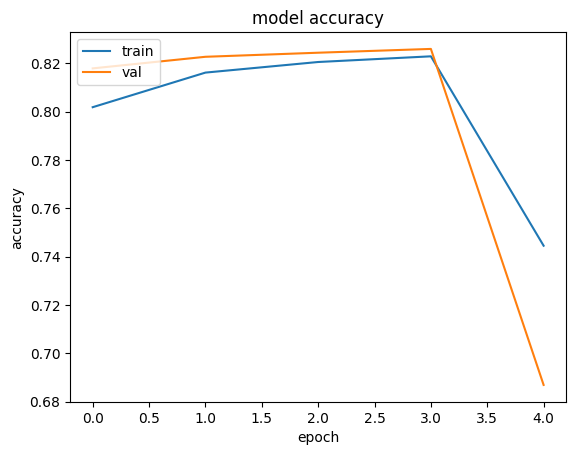

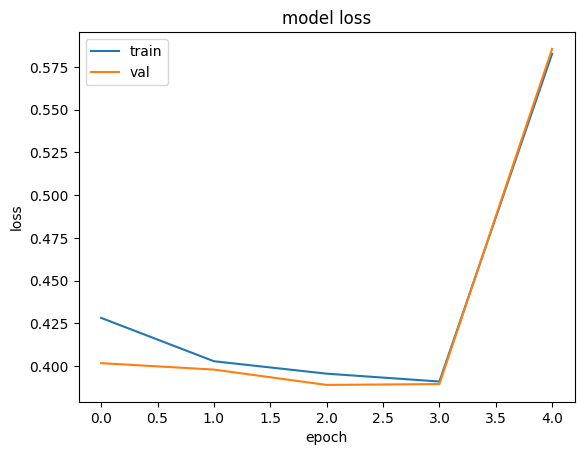

In [29]:
plot_graph(lstm_history)

In [30]:
conv_model = model.conv_model(vocab_size, embedding_dims=embedding_dims,max_len=334,embedding_matrix= EMBEDDINGS_MATRIX)
conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 334, 100)          23942900  
                                                                 
 conv1d (Conv1D)             (None, 330, 16)           8016      
                                                                 
 dropout_8 (Dropout)         (None, 330, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 326, 32)           2592      
                                                                 
 dropout_9 (Dropout)         (None, 326, 32)           0         
                                                                 
 flatten_1 (Flatten)         (None, 10432)             0         
                                                                 
 dense_10 (Dense)            (None, 32)               

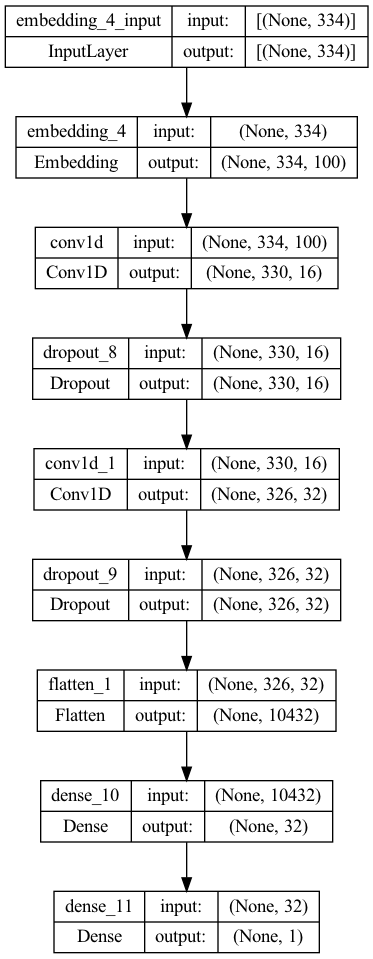

In [31]:
plot_model(conv_model,to_file="conv_model.png", show_shapes=True,show_layer_names=True)

In [32]:
conv_history = conv_model.fit(train_padded_sequence,train_label, epochs=5,validation_data=(val_padded_sequence,val_label))

Epoch 1/5
40000/40000 [==============================] - 280s 7ms/step - loss: 0.4623 - accuracy: 0.7808 - val_loss: 0.4402 - val_accuracy: 0.7943
Epoch 2/5
40000/40000 [==============================] - 279s 7ms/step - loss: 0.4432 - accuracy: 0.7930 - val_loss: 0.4434 - val_accuracy: 0.7940
Epoch 3/5
40000/40000 [==============================] - 284s 7ms/step - loss: 0.4389 - accuracy: 0.7955 - val_loss: 0.4319 - val_accuracy: 0.8012
Epoch 4/5
40000/40000 [==============================] - 292s 7ms/step - loss: 0.4364 - accuracy: 0.7970 - val_loss: 0.4274 - val_accuracy: 0.8055
Epoch 5/5
40000/40000 [==============================] - 282s 7ms/step - loss: 0.4351 - accuracy: 0.7984 - val_loss: 0.4307 - val_accuracy: 0.8031


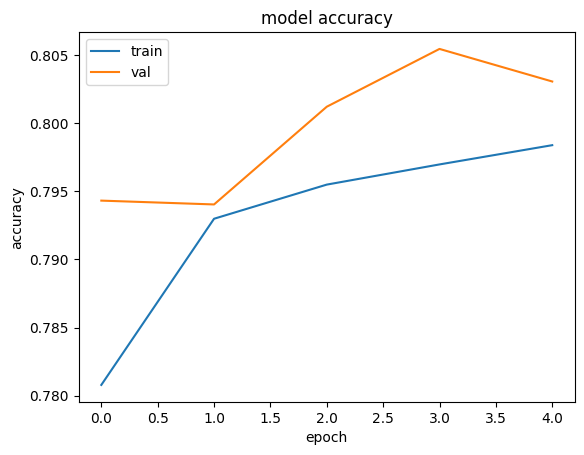

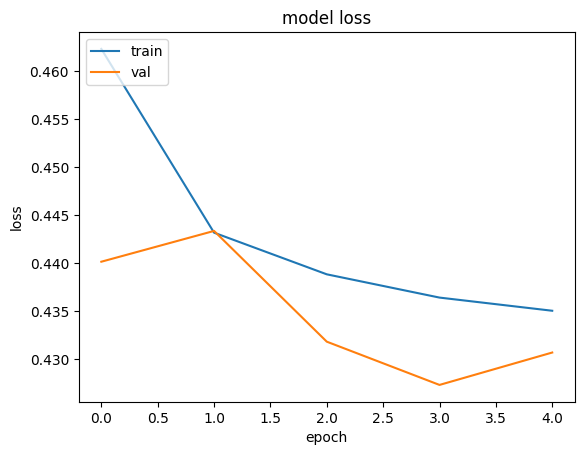

In [33]:
plot_graph(conv_history)